In [1]:
from evalutils import *
from rotationforest import DecisionTreeClassifier
import sklearn
import matplotlib.pyplot as plt

In [132]:
#X, y = get_dataset(1494)
X, y = get_dataset(1489)
#X = X[:1000]
#y = y[:1000]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
np.unique(y)

Read in data frame. Size is 5404 x 6.


array(['1', '2'], dtype='<U1')

In [164]:
import itertools as it
import numpy as np
import sklearn.datasets
import sklearn.decomposition
from tqdm import tqdm
import time

def entropy(p):
    return -sum([q * np.log(q) / np.log(2) if q > 0 else 0 for q in p])

class Node:
    def __init__(self):
        self.split_point = None
        
    def get_depth(self):
        if self.split_point is None:
            return 0
        return 1 + max(self.lc.get_depth(), self.rc.get_depth())
    
    def get_number_of_nodes(self):
        if self.split_point is None:
            return 1
        return 1 + self.lc.get_number_of_nodes() + self.rc.get_number_of_nodes()

class DecisionTreeClassifier:
    
    def __init__(self, eta = 1, pi = 0.99, l = np.inf, p = None, rotation = True, rs = None):
        self.eta = eta
        self.pi = pi
        self.l = l
        self.p = p # the maximum number of (random) attributes to consider in each split. Specify None to use all
        self.rotation = rotation
        self.pca_classes = 2
        self.max_class_combos = 1
        self.min_instances_for_rotation = 5
        self.min_score_to_not_rotate = 0.2
        self.rs = rs if rs is not None else np.random.RandomState()
    
    def train(self, X, y):
        self.num_atts = X.shape[1]
        self.labels = list(np.unique(y))
        
        # scale data
        if self.rotation:
            scaler = sklearn.preprocessing.StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scaler = scaler
        else:
            self.scaler = None
            X_scaled = X
        
        self.model = self.train_tree(X_scaled, y)
    
    def train_tree(self, X, y):
        
        # preliminaries (lines 1-3)
        n = X.shape[0]
        n_unique = len({tuple(row) for row in X})
        ni = [np.count_nonzero(y == l) for l in self.labels]
        majority_label = np.argmax(ni)
        label_order = np.argsort(ni)
        purity = max(ni) / n
        
        # is this a leaf node?
        if n_unique <= self.eta or purity >= self.pi:
            label = self.labels[majority_label]
            n = Node()
            n.label = label
            return n
        
        # initialize decision variables
        split_point, best_score = None, -np.inf
        best_is_numeric_split = True
        X_decision = None
        
        # compute dataset modifications that may be considered for splits
        time_ds_start = time.time()
        datasets = [(X, None, "None")]
        if self.rotation and X.shape[0] > self.min_instances_for_rotation:
            
            # one PCA to the full data
            #pca = sklearn.decomposition.PCA()
            #datasets.append((pca.fit_transform(X_scaled), pca))
            
            # one PCA to the data reduced to each class
            for k in range(1, self.max_class_combos + 1):
                for labelset in it.combinations([self.labels[l] for l in label_order[-self.pca_classes:]], k):#label_order:#[-self.pca_classes:]:
                    pca = sklearn.decomposition.PCA()
                    instances_for_label = X[[l in labelset for l in y]]
                    if len(instances_for_label) >= self.min_instances_for_rotation and np.var(instances_for_label) > 0:
                        try:
                            pca.fit(instances_for_label)
                            X_transformed = pca.transform(X)
                            if X_transformed.shape == X.shape:
                                datasets.append((X_transformed, pca, f"PCA over labelset {labelset}"))
                        except LinAlgError:
                            print("observed error, ignoring result of PCA.")
        time_ds_end = time.time()
        #print(f"Time to compute datasets: {time_ds_end - time_ds_start}")
        
        # get the attributes over which the split might be defined
        indices_of_considered_attributes = list(range(X.shape[1]))
        if self.p is not None:
            num_new_features = min(len(indices_of_considered_attributes), int(self.p))
            indices_of_considered_attributes = sorted(self.rs.choice(indices_of_considered_attributes, num_new_features, replace=False))
        
        #print(f"Now considering {len(datasets)} datasets")
        att_cnt = 0
        for ds_index, (X_local, transformation, trans_name) in enumerate(datasets):
            
            # get the split decision
            for att_index in indices_of_considered_attributes:
                att_cnt += 1
                col = X_local[:, att_index]
                numeric_split = col.dtype in [float, int]
                if numeric_split:
                    v, score = self.evaluate_numeric_attribute(col, y)
                else:
                    v, score = self.evaluate_categorical_attribute(col, y)
                if v is not None and score > best_score:
                    split_point, best_score = (att_index, v), score
                    best_is_numeric_split = numeric_split
                    X_decision = X_local
                    transformation_for_decision = transformation
            
            # break if the standard split was already good enough
            if ds_index == 0 and best_score >= - self.min_score_to_not_rotate:
                break
        
        #print(f"Split point computed after {time.time() - time_ds_end}s. Considered {att_cnt} attributes.")
        
        # we cannot distinguish points here anymore
        if split_point is None:
            label = self.labels[np.argmax(ni)]
            n = Node()
            n.label = label
            return n
        
        # create node with two children
        mask = X_decision[:,split_point[0]] <= split_point[1] if best_is_numeric_split else X_decision[:,split_point[0]] == split_point[1]
        node = Node()
        node.split_point = split_point
        if transformation_for_decision is None:
            node.transformation_vector = None 
            node.offset = None
        else:
            #projection_matrix = np.matmul(transformation_for_decision.components_, transformation_for_decision.components_.T)
            node.transformation_vector = transformation_for_decision.components_[split_point[0]]
            node.transformer = transformation_for_decision
        node.is_numeric = best_is_numeric_split
        node.lc = self.train_tree(X[mask], y[mask])
        node.rc = self.train_tree(X[~mask], y[~mask])
        return node
    
    def evaluate_numeric_attribute(self, col, y):
        
        indices = np.argsort(col)
        M = []
        ni = np.zeros(len(self.labels))
        
        # idfentify all possible split points
        Nvi = {}
        for k, j in enumerate(indices):
            xj = col[j]
            yj = y[j]
            ni[self.labels.index(yj)] += 1
            
            if k < len(col) - 1:
                xjp1 = col[indices[k+1]]
                if xj != xjp1:
                    v = (xj + xjp1) / 2
                    M.append(v)
                    Nvi[v] = ni.copy()
        
        # if there are no split points, return -np.inf
        if not M:
            return None, None
        
        # now evaluate different candidates
        best_v, best_score = None, -np.inf
        for v in M:
            nY = sum(Nvi[v])
            n = len(col)
            nN = n - nY
            wY = nY / n
            wN = nN / n
            pY = np.array(Nvi[v]) / sum(Nvi[v])
            pN = (ni - np.array(Nvi[v])) / sum(ni - np.array(Nvi[v]))
            score = self.gain(wY, wN, pY, pN)
            if score > best_score:
                best_v, best_score = v, score
        return best_v, best_score
    

    def evaluate_categorical_attribute(self, col, y):
        
        # compute nvi counters
        dom = list(np.unique(col))
        if len(dom) == 1:
            return dom[0], -np.inf
        Nvi = np.zeros((len(dom), len(self.labels)))
        for i, v in enumerate(dom):
            for j, label in enumerate(self.labels):
                Nvi[i][j] = np.count_nonzero((col == v) & (y == label))
        
        # compute gains
        best_v, best_score = None, -np.log(len(self.labels)) / np.log(2)
        for v_index, v in enumerate(dom):
            sums_Y = Nvi[v_index]
            sums_N = np.sum(Nvi[[i for i in range(len(dom)) if i != v_index]], axis=0)
            nY = sum(sums_Y)
            nN = sum(sums_N)
            pY = sums_Y / nY if nY > 0 else np.zeros(len(self.labels))
            pN = sums_N / nN if nN > 0 else np.zeros(len(self.labels))            
            score = self.gain(nY / len(col), nN / len(col), pY, pN)
            if score > best_score:
                best_v = v
                best_score = score
        return best_v, best_score
    
    def gain(self, wY, wN, pY, pN):
        return -(wY * entropy(pY) + wN * entropy(pN))
    
    def pass_instance_from_node_to_leaf(self, x, node):
        if node.split_point is None:
            return node
        att, v = node.split_point
        if node.is_numeric:
            val1 = x[att] if node.transformation_vector is None else node.transformer.transform([x])[0][att] #np.dot(node.transformation_vector, x)            
            #val2 = x[att] if node.transformation_vector is None else np.dot(node.transformation_vector, x)
            #print(val1, val2)
            val = val1
            chosen_child = node.lc if val <= v else node.rc
        else:
            chosen_child = node.lc if x[att] == v else node.rc
        return self.pass_instance_from_node_to_leaf(x, chosen_child)
    
    def predict(self, X):
        y = []
        X_scaled = X if self.scaler is None else self.scaler.transform(X)
        for x in X_scaled:
            y.append(self.pass_instance_from_node_to_leaf(x, self.model).label)
        return y
    
    def get_depth(self):
        return self.model.get_depth()
    
    def get_number_of_nodes(self):
        return self.model.get_number_of_nodes()

In [165]:
%%time
o = []
for rotation in [True, False]:
    l = []
    for i in tqdm(range(20)):
        dt = DecisionTreeClassifier(eta=3, pi=0.95, p=np.sqrt(X.shape[1]), rotation=rotation)
        dt.train(X_train, y_train)
        l.append(np.count_nonzero(dt.predict(X_test) == y_test) / len(y_test))
    o.append(l)

100%|██████████| 20/20 [00:34<00:00,  1.75s/it]

CPU times: user 2min 13s, sys: 114 ms, total: 2min 13s
Wall time: 2min 13s


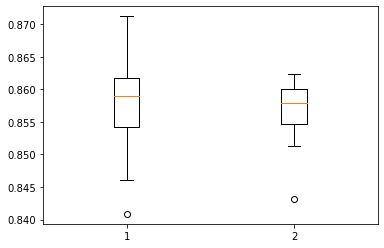

In [166]:
plt.boxplot(o)
plt.show()

In [167]:
print(dt.get_depth())
print(dt.get_number_of_nodes())

22
743


In [5]:
rf_rot = RandomForest(n_trees = 100, rotation = True)
rf_rot.train(X_train, y_train)
depths_rotation = rf_rot.get_depths()
numnodes_rotation = rf_rot.get_numbers_of_nodes()

NameError: name 'RandomForest' is not defined

In [ ]:
rf_normal = RandomForest(n_trees = 100, rotation = False)
rf_normal.train(X_train, y_train)
depths_normal = rf_normal.get_depths()
numnodes_normal = rf_normal.get_numbers_of_nodes()

In [ ]:
fig, ax = plt.subplots(1, 2)#, figsize=(20, 5))
ax[0].boxplot([depths_rotation, depths_normal])
#ax[1].scatter(depths_rotation, depths_normal)
#limit = max(max(depths_rotation), max(depths_normal))
#ax[1].plot([0,limit], [0, limit])
ax[1].boxplot([numnodes_rotation, numnodes_normal])
#ax[3].scatter(numnodes_rotation, numnodes_normal)
#limit = max(max(numnodes_rotation), max(numnodes_normal))
#ax[3].plot([0,limit], [0, limit])
plt.show()

In [ ]:
np.count_nonzero(rf_rot.predict(X_test) == y_test) / len(y_test)

In [ ]:
np.count_nonzero(rf_normal.predict(X_test) == y_test) / len(y_test)

In [ ]:
print(np.mean(depths_rotation) / np.mean(depths_normal))
print(np.mean(numnodes_rotation) / np.mean(numnodes_normal))

In [ ]:
print(np.sum(numnodes_rotation))
print(np.sum(numnodes_normal))


In [ ]:
import pickle 
trees = [rf_rot, rf_normal]
names = ["rotation", "normal"]
for obj, name in zip(trees, names):
    try:
        filehandler = open(name, 'wb')
        pickle.dump(obj, filehandler)
        filehandler.close()
    except:
        print("ERRROR")